In [1]:
# Declare module imports

import numpy as np
from random import randint
import matplotlib.pyplot as plt
import csv
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam

from IPython.core.display import HTML
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set some global variables for storing path to img_data and the driving_log

data_folder = './data/'
path_to_log = data_folder +'driving_log.csv'

In [3]:
# Read in the driving_log
# Print some summary statistics and any random line for some context

logs = []
with open(path_to_log,'rt') as logFile:
    reader = csv.reader(logFile)
    for line in reader:
        logs.append(line)

log_headers = logs[0]
# remove the header from the logs array as we don't require it subsequently
logs.pop(0)
totalLinesFromLog = len(logs) 
# store a random entry for sample printing
randomLineFromLog = randint(0, totalLinesFromLog)

print(' log headers :', log_headers)
print(' total number of log lines :', totalLinesFromLog)
print(' log line selected at random :',randomLineFromLog)
print(' sample log line :',logs[randomLineFromLog])

 log headers : ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
 total number of log lines : 8036
 log line selected at random : 7642
 sample log line : ['IMG/center_2016_12_01_13_46_01_846.jpg', ' IMG/left_2016_12_01_13_46_01_846.jpg', ' IMG/right_2016_12_01_13_46_01_846.jpg', ' -0.1736895', ' 0.9855326', ' 0', ' 30.18681']


In [4]:
# Some css overrides to make the pictures render closer to their titles

HTML('<style>div.output_subarea.output_png { margin-top: -17px;}</style>')

 sample image from input data,  image shape : (160, 320, 3)


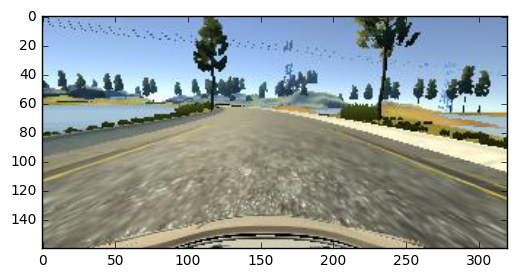

 sample image trimmed,  image shape : (120, 320, 3)


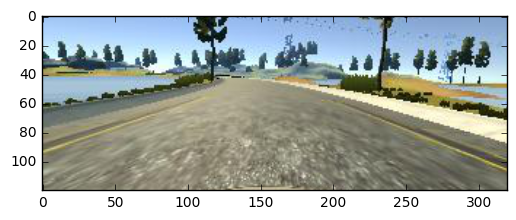

 sample image from input data rescaled,  image shape : (16, 32, 3)


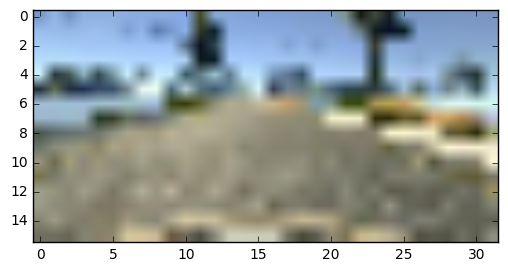

 sample image trimmed and then rescaled  image shape : (16, 32, 3)


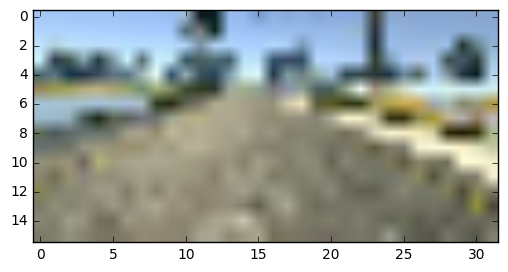

In [5]:
def showImage(img):
    plt.imshow(img)
    plt.show()
    
# Print a sample image and demonastrate rescaling

img = plt.imread(data_folder + logs[randomLineFromLog][0])
print(' sample image from input data, ', 'image shape :',img.shape)
showImage(img)

img_trimmed = img[20:140]
print(' sample image trimmed, ', 'image shape :',img_trimmed.shape)
showImage(img_trimmed)

img_resized = cv2.resize(img,(32,16))
print(' sample image from input data rescaled, ', 'image shape :',img_resized.shape)
showImage(img_resized)

img_trimmed_rescaled = cv2.resize(img_trimmed,(32,16))
print(' sample image trimmed and then rescaled ', 'image shape :',img_trimmed_rescaled.shape)
showImage(img_trimmed_rescaled)

In [6]:
# Helper function to change color space of input data

def image_resize(img):
    return cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(32,16))

In [7]:
# Helper function to normalise input data
# Load features 
#   Get input images from all three cameras vantages
#   Resize each image using helper function above
#   Note that while the log has entries like 
#   ' IMG/center_2016_12_01_13_39_55_956.jpg' with leading spaces, the provided
#   data is actually in the data/IMG/center_2016_12_01_13_39_55_956.jpg location
# Load labels
#   Get steerting angles from all three camera vantages
#   For the left camera add a small delta to the steering angle
#   For the right camera subtract a small delta from the steering angle
        
def load_resized_data(X,y,data_folder,delta=0.1):
    for i in range(len(logs)):
        center_img_path = data_folder+logs[i][0]
        X.append(image_resize(plt.imread(center_img_path)))
        y.append(float(logs[i][3]))
        
        left_img_path = data_folder+logs[i][1].strip()
        X.append(image_resize(plt.imread(left_img_path)))
        y.append(float(logs[i][3]) + delta)
        
        right_img_path = data_folder+logs[i][2].strip()
        X.append(image_resize(plt.imread(right_img_path)))
        y.append(float(logs[i][3]) - delta)

In [8]:
# Call Helper function to Load nornalised data
# this takes about 45 seconds to complete on the udacity-carnd AWS GPU instance

data={}
data['features'] = []
data['labels'] = []
load_resized_data(data['features'], data['labels'],data_folder,0.3)

In [9]:
# Populate standard objects for features and labels

X_train = np.array(data['features']).astype('float32')
y_train = np.array(data['labels']).astype('float32')

In [10]:
# Augment feature and labels via reflection of existing features and labels

X_train = np.append(X_train,X_train[:,:,::-1],axis=0)
y_train = np.append(y_train,-y_train,axis=0)

In [11]:
# Train and test validation splits and print some summaries

X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

In [12]:
# Reshape train features and labels

img_rows = 16
img_cols = 32
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [13]:
# Main Keras Model for the training run
# The lambda model eventually leads to a json with encode spaces and requires
# at least keras 1.2.0 , upon a model save/restore

def normalize_greyscale(image_data):
    return  (image_data/((0+255)/2)) -1

model = Sequential()
model.add(Lambda(normalize_greyscale ,input_shape=(16,32,1)))
model.add(Conv2D(2, 3, 3, border_mode='valid', input_shape=(16,32,1), activation='relu'))
model.add(MaxPooling2D((4,4),(4,4),'valid'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1))

# Visualize model
from keras.utils.visualize_util import plot
plot(model, to_file='output_for_writeup/model.png')

In [14]:
# Main training runs for the Keras model
# This takes about 3 minutes on an AWS GPU

model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train,batch_size=128, nb_epoch=20,verbose=1, validation_data=(X_val, y_val))

Train on 43394 samples, validate on 4822 samples
Epoch 1/20
43394/43394 [==============================] - 2s - loss: 0.2217 - val_loss: 0.0606

In [15]:
# Print Model predictions

model.predict(X_train[0:5])

array([[ 0.04958863],
       [ 0.01303186],
       [-0.10210057],
       [-0.06940428],
       [-0.13637753]], dtype=float32)

In [16]:
# Save model (as json) and weights to disk

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Wrote model and weights to disk")

Wrote model and weights to disk
